This example is taken from the `pyunfold` tutorial which you can find here: [https://jrbourbeau.github.io/pyunfold/notebooks/tutorial.html](https://jrbourbeau.github.io/pyunfold/notebooks/tutorial.html)
The `pyunfold` API documentation is here: [https://jrbourbeau.github.io/pyunfold/api.html](https://jrbourbeau.github.io/pyunfold/api.html)

Having measured some yields in bins of a reconstructed variable we want to estimate the yields as a function of the true variable. This requires undoing experimental resolution effects with unfolding. Here we have an example using `pyunfold`, which uses the Iterative Bayesian unfolding algorithm.

In [1]:
import pyunfold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

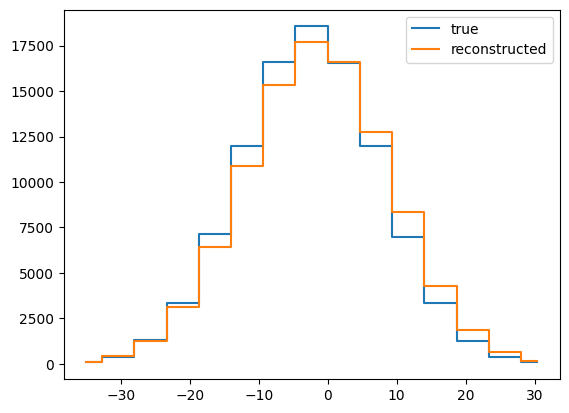

In [72]:
# First generate some toy data from a Gaussian function, centred at 0, with width 10.
true_data = np.random.normal(0., 10., size = 100000)
# And now add some random smearing and bias due to experimental resolution - another Gaussian with width 5.
noise = np.random.normal(1., 3., size = 100000)
reco_data = true_data + noise
# And now put into 15 bins and plot:
bins = np.linspace(-35, 35, 16)
num_bins = 15
true_bins, _ = np.histogram(true_data, bins = bins)
reco_bins, _ = np.histogram(reco_data, bins = bins)
plt.figure()
plt.step(bins[:num_bins], true_bins, label = "true", where = "mid")
plt.step(bins[:num_bins], reco_bins, label = "reconstructed", where = "mid")
plt.legend()

To unfold we need to use a reponse matrix - this describes the probability that an event that is truely in bin $i$ ends up in bin $j$

In [73]:
# Make a 2D histogram from our true and reconstructed samples
response_hist, _, _ = np.histogram2d(reco_data, true_data, bins=bins)
# And a 2D histogram of the uncertainty of our response matrix - here we just consider the MC sample size
response_hist_err = np.sqrt(response_hist)

# Now normalise the histogram such that the probability of reconstructing a true data event sums to 1
# over all the reconstructed bins
column_sums = response_hist.sum(axis=0)
normalization_factor = 1. / column_sums
response = response_hist * normalization_factor
response_err = response_hist_err * normalization_factor

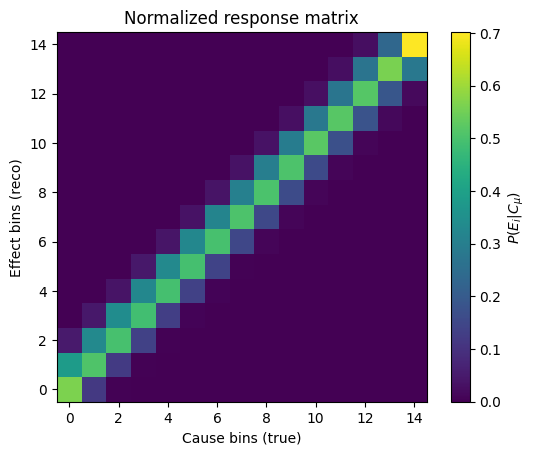

In [74]:
fig, ax = plt.subplots()
im = ax.imshow(response, origin='lower')
cbar = plt.colorbar(im, label='$P(E_i|C_{\mu})$')
ax.set(xlabel='Cause bins (true)', ylabel='Effect bins (reco)',
       title='Normalized response matrix')
plt.show()

Now we can set up the unfolding. `pyunfold` allows for you to include efficiency effects in the unfolding - we will ignore that here and just set all the efficiencies to 1 with 0 uncertainty

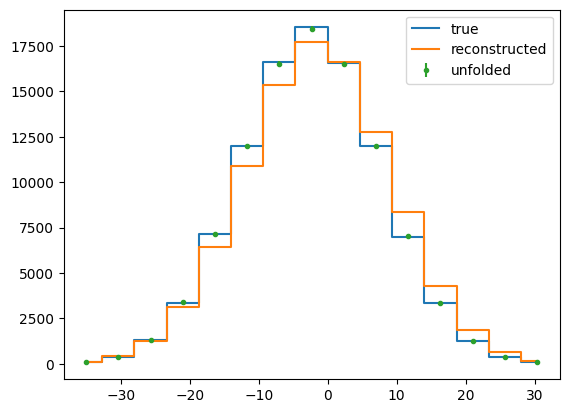

In [77]:
unfolded_results = pyunfold.iterative_unfold(data=reco_bins,
                                    data_err=np.sqrt(reco_bins),
                                    response=response,
                                    response_err=response_err,
                                    efficiencies=[1. for i in range(num_bins)],
                                    efficiencies_err=[0. for i in range(num_bins)])
# And add the unfolded yields to the first plot
plt.figure()
plt.step(bins[:num_bins], true_bins, label = "true", where = "mid")
plt.step(bins[:num_bins], reco_bins, label = "reconstructed", where = "mid")
plt.errorbar(bins[:num_bins], unfolded_results['unfolded'], yerr = unfolded_results['stat_err'], label = "unfolded",
             ls = "None", marker = ".")
plt.legend()

The unfolded distribution reproduces the true one!

This is a very basic example. In reality we use a MC sample to find the response matrix which will bring in extra uncertainty due to know data/MC differences. Furthermore the MC used to construct the response matrix may not have the exact true distribution of the data - what if the underlying physics in the data does not match the MC.

There are some extra parameters to try out for more complicated cases. In particular with iterative unfolding one can control when the iteration stops. With `pyunfold` you do this by setting the maximum allowed difference between successive iterations before the algorithm stops. You can also try a different prior probability distribution. The prior represents your best guess at what the true distribution is to get the initial unfolding steps into the right kind of region. The choice of prior can have an effect on the result, particularly if you have very noisey data or large statistical fluctuations.